<a href="https://colab.research.google.com/github/Asdaois/image-to-model/blob/main/Text_to_Point_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install plotly -q

In [ ]:
!git clone https://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 7), reused 51 (delta 7), pack-reused 0
Unpacking objects: 100% (57/57), 1.56 MiB | 5.70 MiB/s, done.


In [ ]:
%cd point-e

/content/point-e/point-e


In [ ]:
! pip install -e . -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


### Imports

In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

### Models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base300M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[
        base_model 
        , upsampler_model
        ],
    diffusions=[base_diffusion
                , upsampler_diffusion
                ],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg


In [ ]:
! pip install 

In [ ]:
image_1 = Image.open('1.jpg')
image_2 = Image.open('2.jpg')
image_3 = Image.open('3.jpg')
image_4 = Image.open('4.jpg')
image_5 = Image.open('5.jpg')
image_6 = Image.open('6.jpg')

images = [
    # image_1, 
    # image_2, 
    image_3, 
    # image_4, 
    image_5, 
    # image_6
    ]

# Produce a sample from the model.
samples = None
for x in tqdm(
    sampler.sample_batch_progressive(
        batch_size= (len(images) if len(images) > 0 else 1), 
        model_kwargs=dict(
            images = images)
        )
    ):
    samples = x

0it [00:00, ?it/s]

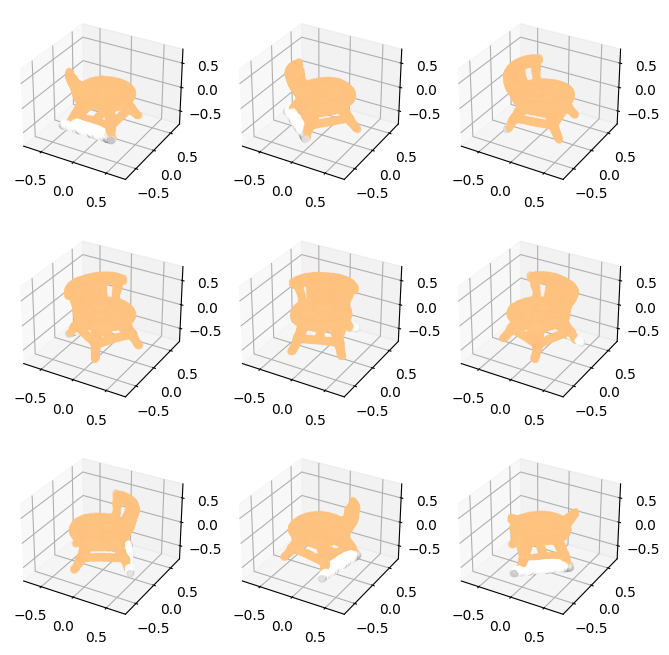

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
pc.save('pointcloud.npz')
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
import plotly.graph_objects as go
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )
fig_plotly.show(renderer="colab")

In [ ]:
from point_e.util.pc_to_mesh import marching_cubes_mesh

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

In [ ]:
import skimage.measure as measure


In [ ]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=128, # increase to 128 for resolution used in evals
    progress=True,
)

In [ ]:
# Write the mesh to a PLY file to import into some other program.
with open('mesh.ply', 'wb') as f:
    mesh.write_ply(f)